# Optimal Ansatz / Optimizer Combination

What combination of ansatz and optimizer results in the best objective function.

In [1]:
import time
start_time = time.time()
#from qiskit_ibm_provider import IBMProvider
# provider = IBMProvider()

In [2]:
# Standard imports
import numpy as np
import pandas as pd
import time
import warnings

# Qiskit 
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, EfficientSU2
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.primitives import Sampler
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B, ADAM, SLSQP, AQGD
from qiskit_machine_learning.utils import algorithm_globals
# Visualization libraries
from matplotlib import pyplot as plt
import seaborn as sns
from qiskit.visualization import plot_histogram
from IPython.display import clear_output

# Machine learning and preprocessing
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from functools import partial

In [3]:
df  = pd.read_csv("https://raw.githubusercontent.com/hongsukyi/Lectures/main/data/vds_label_by_hour_150.csv")
df=df[['ToVol', 'hour', 'Speed', 'OccRate','label3']]; 
features = np.array(df[df.columns[0:-1]])
labels = np.array(df['label3'])
features[:5,:]

array([[ 17.  ,   2.  ,  53.3 ,   0.89],
       [100.  ,   6.  ,  53.3 ,   3.56],
       [ 14.  ,   2.  ,  57.4 ,   0.63],
       [ 59.  ,  22.  ,  50.  ,   2.51],
       [104.  ,   6.  ,  56.9 ,   3.6 ]])

In [4]:
features[:5,:], labels[:5]

(array([[ 17.  ,   2.  ,  53.3 ,   0.89],
        [100.  ,   6.  ,  53.3 ,   3.56],
        [ 14.  ,   2.  ,  57.4 ,   0.63],
        [ 59.  ,  22.  ,  50.  ,   2.51],
        [104.  ,   6.  ,  56.9 ,   3.6 ]]),
 array(['Fast', 'Fast', 'Fast', 'Fast', 'Fast'], dtype=object))

In [5]:
features = MinMaxScaler().fit_transform(features)
algorithm_globals.random_seed = 4701

train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size = 0.8, random_state = algorithm_globals.random_seed)
num_features = features.shape[1]

In [6]:
sampler = Sampler()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3920\3042598456.py:1: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


In [7]:
objective_func_vals = []
plt.rcParams['figure.figsize'] = (12,6)
def callback_graph(weights, obj_func_eval):
             
    if combo_identifier not in objective_func_vals_dict:
        objective_func_vals_dict[combo_identifier] = []
    objective_func_vals_dict[combo_identifier].append(mean)

    clear_output(wait=True)
    for identifier, values in objective_func_vals_dict.items():
        plt.plot(values, label=identifier)
    
    plt.title('Objective function value against Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Objective function value')
    plt.legend()
    plt.show()

In [8]:
feature_dimension = 4
optimizers = [COBYLA(maxiter=100), SLSQP(maxiter=100)]   # yi: 100--> 10 
ansatzes = [RealAmplitudes, EfficientSU2]
reps_range = range(1, 6, 2)                               # yi: 5 --> 2

combinations = [
    {"optimizer": optimizer, "ansatz": ansatz(feature_dimension, reps=reps)}
    for optimizer in optimizers
    for ansatz in ansatzes
    for reps in reps_range
]

sampler = Sampler()


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3920\4192923883.py:13: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


In [9]:
from functools import partial
import matplotlib.pyplot as plt
from IPython.display import clear_output


objective_func_vals_dict = {}


def callback_graph(combo_identifier, objective_func_vals_dict, eval_count, mean):
    if combo_identifier not in objective_func_vals_dict:
        objective_func_vals_dict[combo_identifier] = []
    objective_func_vals_dict[combo_identifier].append(mean)

    
    clear_output(wait=True)
    for identifier, values in objective_func_vals_dict.items():
        plt.plot(values, label=identifier)

    plt.title('Objective function value against Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Objective function value')
    plt.legend()
    plt.show()

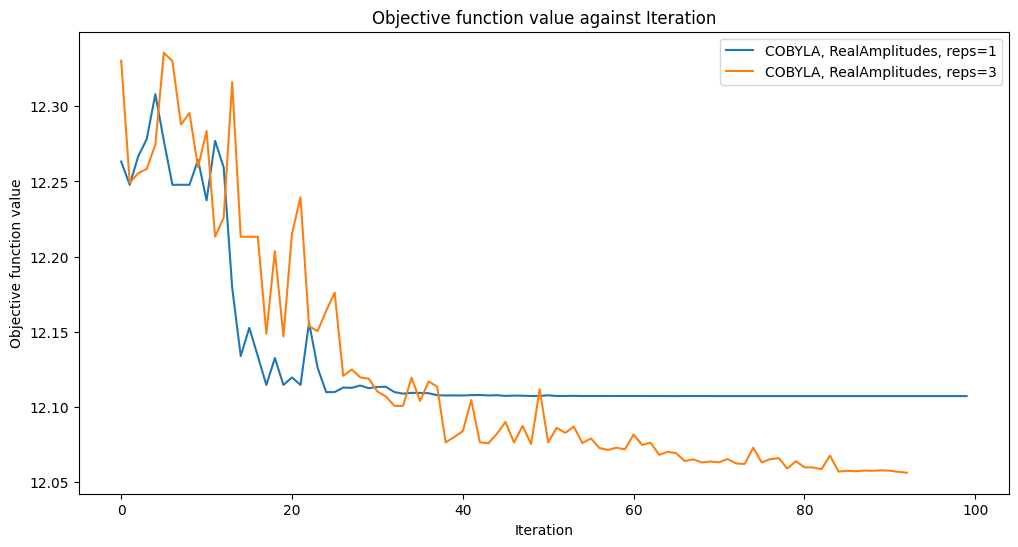

In [ ]:
results = []

for combo in combinations:
    optimizer = combo["optimizer"]
    ansatz = combo["ansatz"]
    reps = ansatz.reps
    optimizer_name = type(optimizer).__name__
    ansatz_name = type(ansatz).__name__
    combo_identifier = f"{optimizer_name}, {ansatz_name}, reps={reps}"
    feature_map = ZZFeatureMap(feature_dimension=feature_dimension, reps=1)

    unique_callback = partial(callback_graph, combo_identifier, objective_func_vals_dict)
    
    vqc = VQC(feature_map=feature_map,
              ansatz=ansatz,
              optimizer=optimizer,
              callback=unique_callback,  
              sampler=sampler)

    
    objective_func_vals_dict[combo_identifier] = []
    
    start_time = time.time()
    vqc.fit(train_features, train_labels)
    elapsed_time = time.time() - start_time
    score = vqc.score(test_features, test_labels)

    results.append({
        "combo_identifier": combo_identifier,
        "optimizer": optimizer_name,
        "ansatz": ansatz_name,
        "ansatz_reps": reps,
        "training_time": elapsed_time,
        "score": score
    })

In [9]:
data = []
for combo, vals in objective_func_vals_dict.items():
    for iteration, value in enumerate(vals, 1):
        optimizer, ansatz, reps = combo.split(", ")
        data.append({"Optimizer": optimizer, "Ansatz": ansatz, "Reps": reps.split("=")[-1], "Iteration": iteration, "Value": value})
df = pd.DataFrame(data)

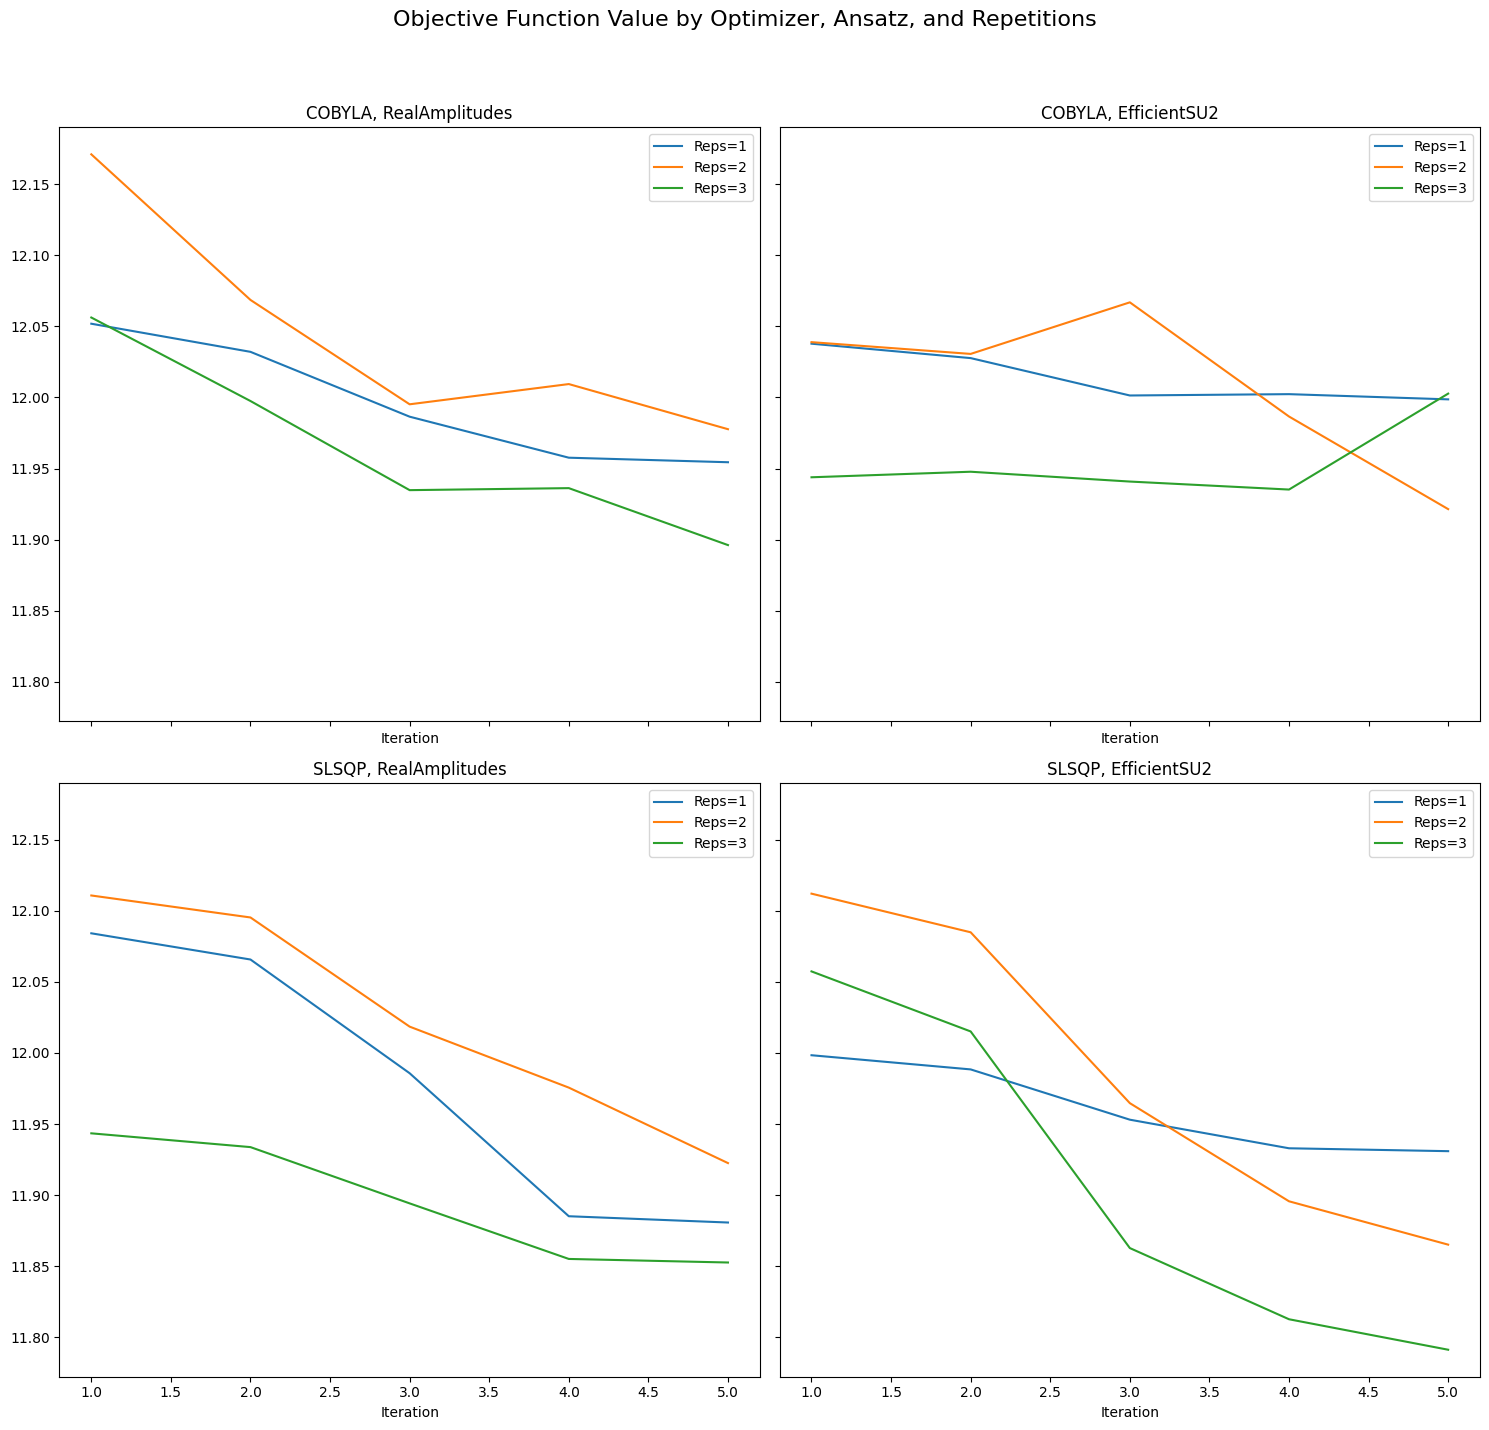

In [10]:
# Plotting
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15), sharex=True, sharey=True)
axs = axs.flatten()

optimizers = df['Optimizer'].unique()
ansatzes = df['Ansatz'].unique()

for i, optimizer in enumerate(optimizers):
    for j, ansatz in enumerate(ansatzes):
        ax = axs[i * len(ansatzes) + j]
        subset = df[(df['Optimizer'] == optimizer) & (df['Ansatz'] == ansatz)]
        
        for reps in subset['Reps'].unique():
            reps_subset = subset[subset['Reps'] == reps]
            ax.plot(reps_subset['Iteration'], reps_subset['Value'], label=f'Reps={reps}')
        
        ax.set_title(f'{optimizer}, {ansatz}')
        ax.set_xlabel('Iteration')
        ax.legend()

plt.suptitle("Objective Function Value by Optimizer, Ansatz, and Repetitions", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [11]:
df_results = pd.DataFrame(results)

In [12]:
df_results

,combo_identifier,optimizer,ansatz,ansatz_reps,training_time,score
0,"COBYLA, RealAmplitudes, reps=1",COBYLA,RealAmplitudes,1,5.348180,0.433333
1,"COBYLA, RealAmplitudes, reps=2",COBYLA,RealAmplitudes,2,5.572781,0.500000
2,"COBYLA, RealAmplitudes, reps=3",COBYLA,RealAmplitudes,3,6.347580,0.533333
3,"COBYLA, EfficientSU2, reps=1",COBYLA,EfficientSU2,1,5.963738,0.366667
4,"COBYLA, EfficientSU2, reps=2",COBYLA,EfficientSU2,2,7.060606,0.333333
5,"COBYLA, EfficientSU2, reps=3",COBYLA,EfficientSU2,3,7.811983,0.400000
6,"SLSQP, RealAmplitudes, reps=1",SLSQP,RealAmplitudes,1,60.116039,0.400000
7,"SLSQP, RealAmplitudes, reps=2",SLSQP,RealAmplitudes,2,100.287272,0.433333
8,"SLSQP, RealAmplitudes, reps=3",SLSQP,RealAmplitudes,3,144.054866,0.466667
9,"SLSQP, EfficientSU2, reps=1",SLSQP,EfficientSU2,1,132.269490,0.433333


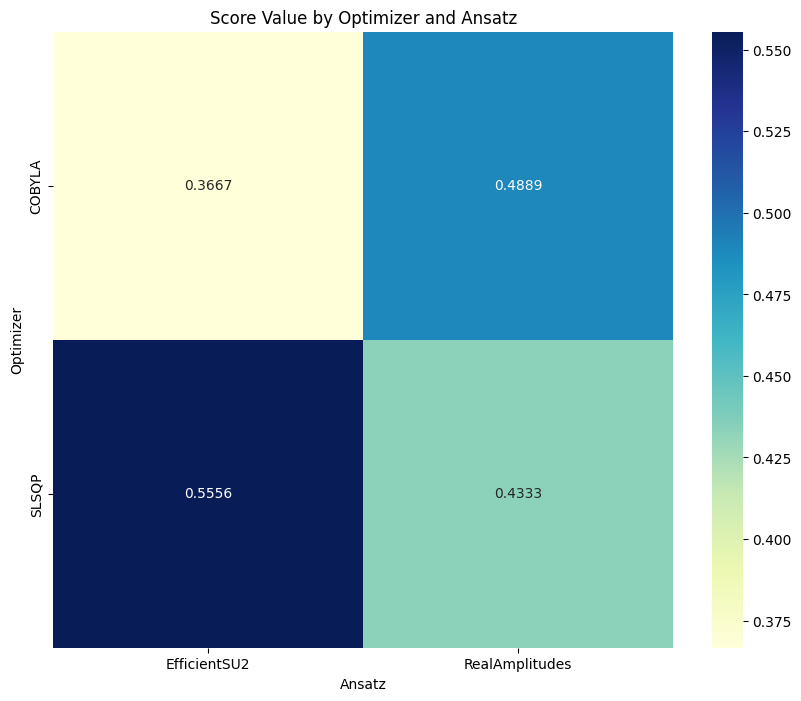

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = df_results 
heatmap_data = df.groupby(['optimizer', 'ansatz'])['score'].mean().unstack()


plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".4f")
plt.title('Score Value by Optimizer and Ansatz')
plt.ylabel('Optimizer')
plt.xlabel('Ansatz')
plt.show()

In [14]:
data = []
for combo, vals in objective_func_vals_dict.items():
    for iteration, value in enumerate(vals, 1):
        optimizer, ansatz, reps = combo.split(", ")
        data.append({"Optimizer": optimizer, "Ansatz": ansatz, "Reps": reps.split("=")[-1], "Iteration": iteration, "Value": value})
df = pd.DataFrame(data)

In [15]:
df_results

,combo_identifier,optimizer,ansatz,ansatz_reps,training_time,score
0,"COBYLA, RealAmplitudes, reps=1",COBYLA,RealAmplitudes,1,5.348180,0.433333
1,"COBYLA, RealAmplitudes, reps=2",COBYLA,RealAmplitudes,2,5.572781,0.500000
2,"COBYLA, RealAmplitudes, reps=3",COBYLA,RealAmplitudes,3,6.347580,0.533333
3,"COBYLA, EfficientSU2, reps=1",COBYLA,EfficientSU2,1,5.963738,0.366667
4,"COBYLA, EfficientSU2, reps=2",COBYLA,EfficientSU2,2,7.060606,0.333333
5,"COBYLA, EfficientSU2, reps=3",COBYLA,EfficientSU2,3,7.811983,0.400000
6,"SLSQP, RealAmplitudes, reps=1",SLSQP,RealAmplitudes,1,60.116039,0.400000
7,"SLSQP, RealAmplitudes, reps=2",SLSQP,RealAmplitudes,2,100.287272,0.433333
8,"SLSQP, RealAmplitudes, reps=3",SLSQP,RealAmplitudes,3,144.054866,0.466667
9,"SLSQP, EfficientSU2, reps=1",SLSQP,EfficientSU2,1,132.269490,0.433333


In [17]:
df.head()

,Optimizer,Ansatz,Reps,Iteration,Value
0,COBYLA,RealAmplitudes,1,1,12.051845
1,COBYLA,RealAmplitudes,1,2,12.032067
2,COBYLA,RealAmplitudes,1,3,11.986457
3,COBYLA,RealAmplitudes,1,4,11.957607
4,COBYLA,RealAmplitudes,1,5,11.954416


In [19]:
norm_training_time = (df_results['training_time'] - df_results['training_time'].min()) / (df_results['training_time'].max() - df_results['training_time'].min())

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df['score'], df.index, c=norm_training_time, cmap='viridis')
plt.colorbar(label='Normalized Training Time')
plt.yticks(df.index, df['combo_identifier'])
plt.xlabel('Score')
plt.title('Scores Colored by Training Time')
plt.gca().invert_yaxis()  # Optional: Invert y-axis so top is best
plt.show()

KeyError: 'score'

<Figure size 1000x600 with 0 Axes>

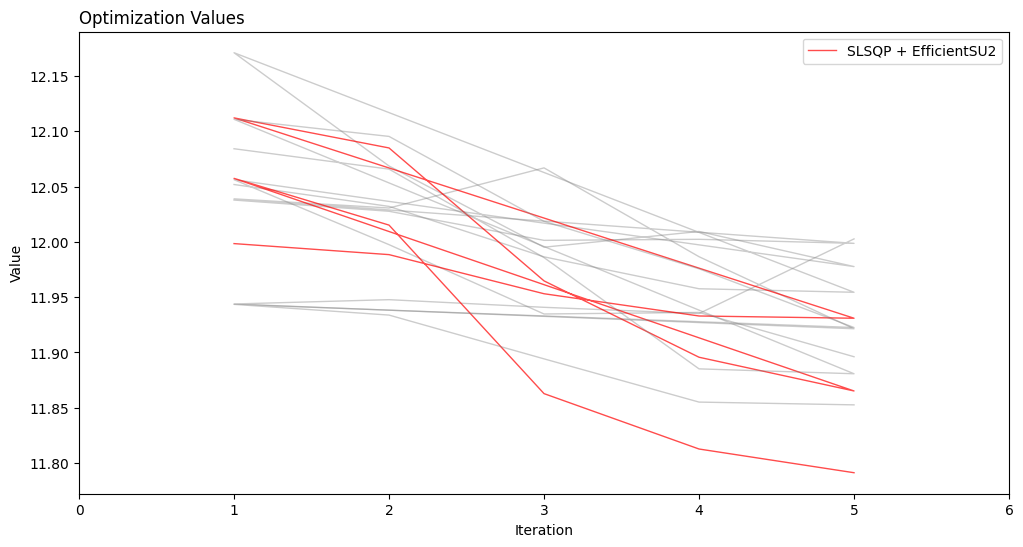

In [20]:
for (optimizer, ansatz), group in df.groupby(['Optimizer', 'Ansatz']):
    color = 'red' if optimizer == "SLSQP" and ansatz == "EfficientSU2" else 'grey'
    alpha = 0.7 if optimizer == "SLSQP" and ansatz == "EfficientSU2" else 0.4
    label = f"{optimizer} + {ansatz}" if optimizer == "SLSQP" and ansatz == "EfficientSU2" else None
    plt.plot(group['Iteration'], group['Value'], marker='', color=color, linewidth=1, alpha=alpha, label=label)

group.sort_values('Iteration', inplace=True)

plt.xlim(0, max(df['Iteration'])+1)
plt.title("Optimization Values", loc='left', fontsize=12, fontweight=0, color='Black')
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.legend()

# Show the plot
plt.show()

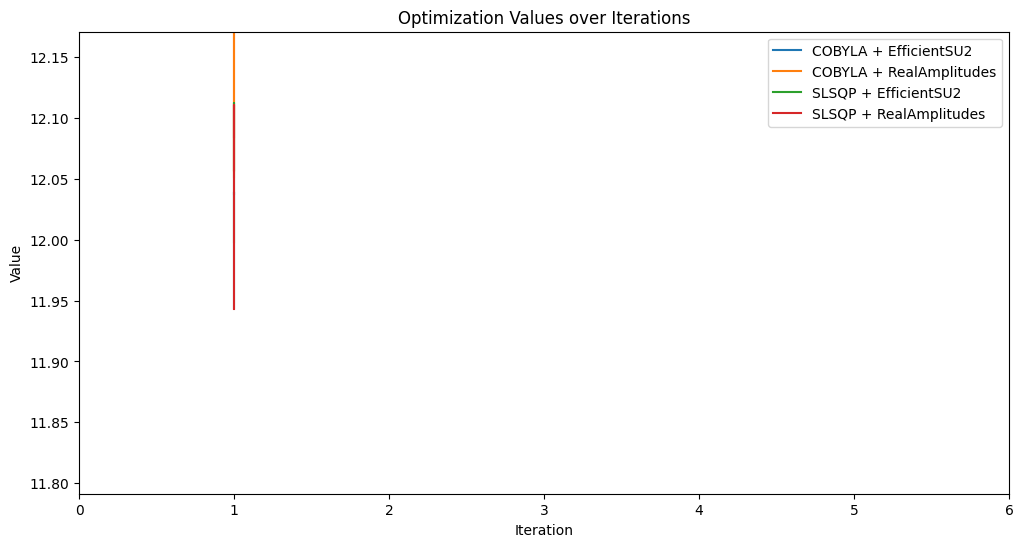

In [21]:
%matplotlib inline
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd
import numpy as np

fig, ax = plt.subplots()

# Define the update function for animation
def update(frame):
    ax.clear()  # Clear previous lines
    for (optimizer, ansatz), group in df[df['Iteration'] <= frame].groupby(['Optimizer', 'Ansatz']):
        group_sorted = group.sort_values(by='Iteration')
        ax.plot(group_sorted['Iteration'], group_sorted['Value'], marker = '', label=f"{optimizer} + {ansatz}")
    ax.legend(loc='upper right')
    ax.set_xlim(0, df['Iteration'].max() + 1)
    ax.set_ylim(df['Value'].min(), df['Value'].max())
    ax.set_title('Optimization Values over Iterations')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Value')

# Create the animation
ani = FuncAnimation(fig, update, frames=np.arange(1, df['Iteration'].max() + 1), repeat=False)

# To display the animation in JupyterLab
HTML(ani.to_jshtml())


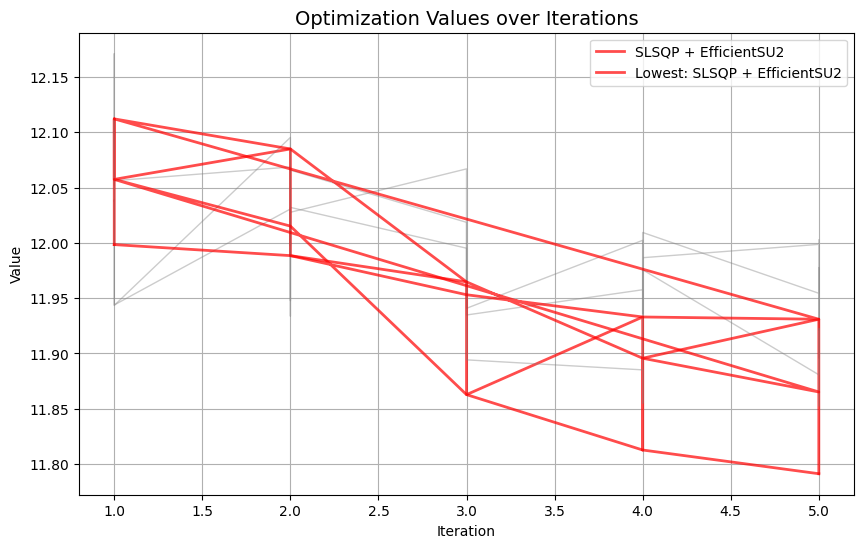

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'df' is your DataFrame and it contains the columns: 'Optimizer', 'Ansatz', 'Iteration', 'Value'

# Find the combination with the lowest score
lowest_score = df['Value'].min()
lowest_combination = df[df['Value'] == lowest_score][['Optimizer', 'Ansatz']].iloc[0]
lowest_optimizer, lowest_ansatz = lowest_combination

# Initialize the figure
plt.figure(figsize=(10, 6))

# Plot all combinations with a basic style
# Correct approach to plotting within the groupby loop
for (optimizer, ansatz), group in df.groupby(['Optimizer', 'Ansatz']):
    # Sort the group by 'Iteration' to ensure the line plot is continuous and ordered correctly
    group = group.sort_values('Iteration')
    if optimizer == "SLSQP" and ansatz == "EfficientSU2":
        plt.plot(group['Iteration'], group['Value'], marker='', color='red', linewidth=2, alpha=0.7, label=f"{optimizer} + {ansatz}")
    else:
        plt.plot(group['Iteration'], group['Value'], marker='', color='grey', linewidth=1, alpha=0.4)


# Highlight the lowest scoring combination
lowest_group = df[(df['Optimizer'] == lowest_optimizer) & (df['Ansatz'] == lowest_ansatz)]
plt.plot(lowest_group['Iteration'], lowest_group['Value'], marker='', color='red', linewidth=2, alpha=0.7,
         label=f"Lowest: {lowest_optimizer} + {lowest_ansatz}")

# Customization
plt.title("Optimization Values over Iterations", fontsize=14)
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [23]:
end_time = time.time()
total_runtime = end_time - start_time
print(f"Total Notebook Runtime: {total_runtime} seconds")

Total Notebook Runtime: 2485.728912115097 seconds
